# Extract feature maps from a CNN

This notebook shows how you can print the feature maps from a model in Tensorflow.


In [42]:
# some helpful packages
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow.keras as keras

%matplotlib inline

Let's start by loading the CIFAR dataset. We will load the CIFAR-10 dataset found in keras that contains common images with 10 classes. These images are small(32 by 32 pixels), and are 3-channel RGB images.






In [43]:
# load the training and testing data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
img_cols, img_rows, img_chs = x_train.shape[1:]

# normalize the images from [0,1]
x_train = x_train / 255
x_test = x_test / 255


# Load a Model 

We will be using one of Keras' pretrained models. This will be **VGG16**. We will not train this model, but we will output the feature maps created from each layer from an input image.


In [44]:
# we will load VGG16 with the following line. Here we can specify the shape of the input image, the training weights, and if the last few layers of the model will or willnot be included
base_model =  keras.applications.vgg16.VGG16(input_shape=[img_cols, img_rows, img_chs], include_top = False, pooling="avg", weights = 'imagenet')

In [45]:
num_outputs = num_classes

# add output layers
x = keras.layers.Dense(128, activation='relu')(base_model.output)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# we need to ensure there are 10 nodes in this layer because we have 10 classes.
x = keras.layers.Dense(num_outputs, activation='sigmoid')(x)

model = keras.models.Model(inputs = base_model.input, outputs = x)    


In [46]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
              
# display a summary of the model              
display(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

None

# Visualize Feature Maps

The feature maps are the output tensors after a kernel has been applied. The following is a diagram of a basic CNN. The feature maps would be the grey squares. The first layer is the input layer. The second layer has 8 feature maps, the third has 24 and the fourth has 24.

 ![alt text](Diagrams/BasicCNN.png/)

In [47]:
def FeatureMaps(model, start_layer, end_layers, test_img):
    """
    This function reads in a model, and outputs the feature maps at each layer of the model. 
    The layers that will be outputted are specified using start_layer, and end_layers. These
    two values indicate the range of layers to be outputted.

    Parameters
    ----------
    model : tensorflow model
        A CNN model.
    start_layer : int
        Indicates what is the first layer to be included in the feature maps. Use 0 
        if you intend to start at the input layer.
    end_layers : int
        Indicates what is the last layer to be included in the feature maps
    test_img : numpy array
        An numpy array containing the input image. 

    Returns
    -------
    activations : list
        This is a list of feature maps generated by 'model', with an input image 'test_img'.
        Each layer may have one, or several feature maps.
    layer_name : list
        List of strings. This indicates the name of each layer.

    """

    layer_names = [layer.name for layer in model.layers[start_layer:end_layers]]
    layer_outputs = [layer.get_output_at(0) for layer in model.layers[start_layer:end_layers]]
    
    # Creates a model that will return these outputs, given the model input
    activation_model = keras.Model(inputs=model.get_input_at(0), outputs=layer_outputs)   
    feature_maps = activation_model.predict([[test_img]])

    return feature_maps, layer_names

Now we can input a test image, and start to see what the feature maps look like.

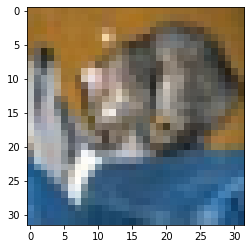

In [48]:
# plot input image
plt.imshow(x_test[0])

# generate feature maps and display them
feature_maps, layer_names = FeatureMaps(model, 0, 10, [x_test[0:1]])


'feature_maps' is a variable that contains all the feature maps from layer 0 to layer 10. This means the first layer (input_1) is the input layer and is just the input image. We can plot this input image and a feature map from the next layer.

If you want, you can plot other layers or feature maps.

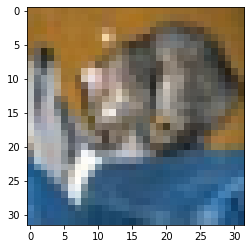

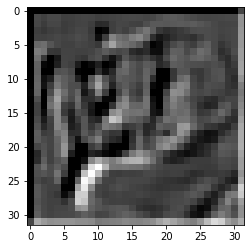

In [49]:
# if we plot the value in feature map we get the input image. This is because we specified
# the first layer which is the input layer. 
plt.imshow(feature_maps[0][0,:,:,:])
plt.show()

# we can instead plot an image from the model after the first convolutional layer.
plt.imshow(feature_maps[1][0,:,:,0], cmap='gray')
plt.show()

If we want to plot all of the feature maps in a nice format we can make a quick function for that. Here I made a function that creates a figure, then plots all feature maps from one layer in that figure. It then labels that figure with the name of that layer.

This function only displays the figures. If you want, you can adjust so it automatically saves the figures. This may be useful when interpreting preformance or results.

In [50]:
def PlotImages(imgs, name, num_imgs):
    """
    Plots images in imgs (a numpy array). Assumes that imgs has multiple images,
    and will parse through the last index of the numpy array to plot all images
    in a N by M plot. Assumes images are greyscale. 

    Parameters
    ----------
    imgs : numpy array
        Numpy array containg the images. Index using the last dimension in the
        array to index through the images.
    name : string
        Name of layer.
    num_imgs : int
        Number of images contained in imgs.

    Returns
    -------
    None.

    """
    
    # calculate required number of columns
    columns = math.floor(np.sqrt(num_imgs))
    rows = math.ceil(num_imgs/columns)
    
    fig = plt.figure(figsize = (8,8)) 

    for i in range(0, columns*rows):
        # condition where the last row has a few empty spaces
        if i < num_imgs:
            img = imgs[0,:,:,i]
            fig.add_subplot(rows, columns, i+1)
            
            # default colour pallet is viridian. 
            plt.imshow(img, cmap = 'gray')
            # turn off axis
            plt.axis('off')            
    
    fig.suptitle(name)        
    plt.show()

When we plot it this way the first layer (input_1), is the input image split into it's three colour channels.

Notice how after each pooling layer, the image get's smaller. 

You can match each set of feature maps, to output of **model.summary()**. You can see each layer, it's name and it's dimensions.




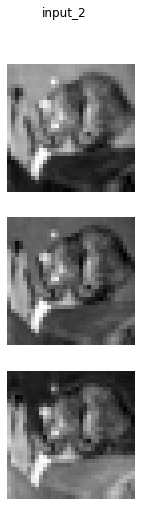

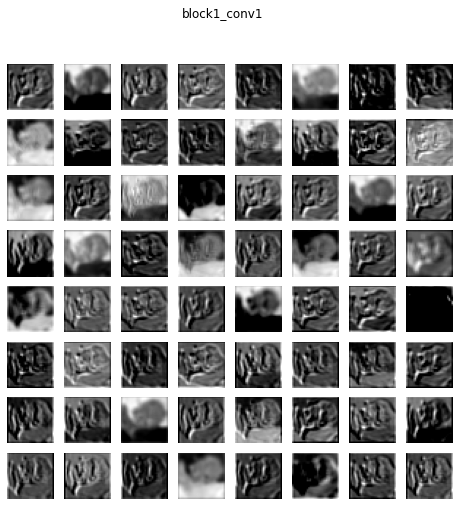

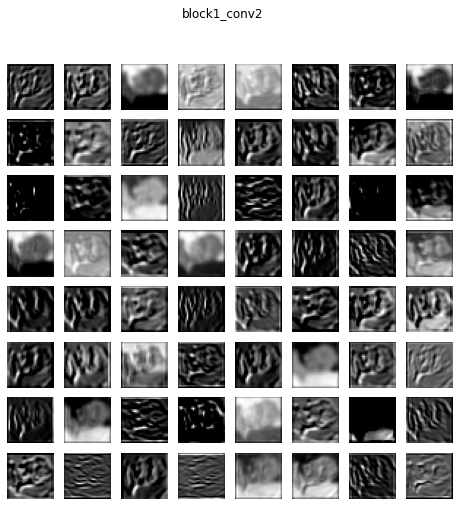

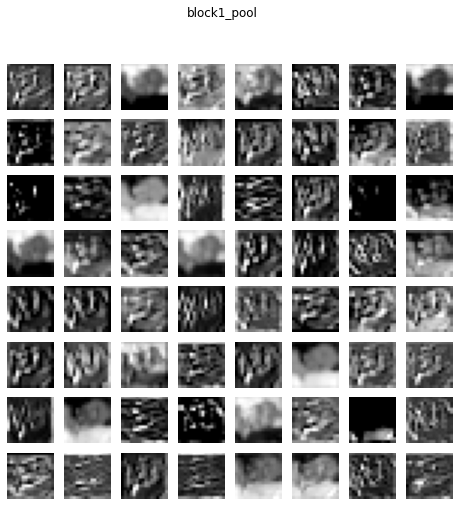

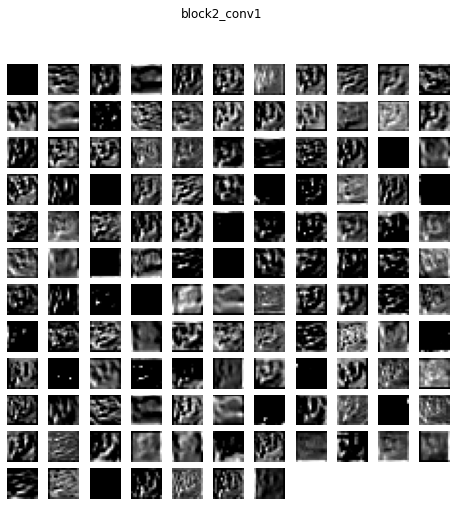

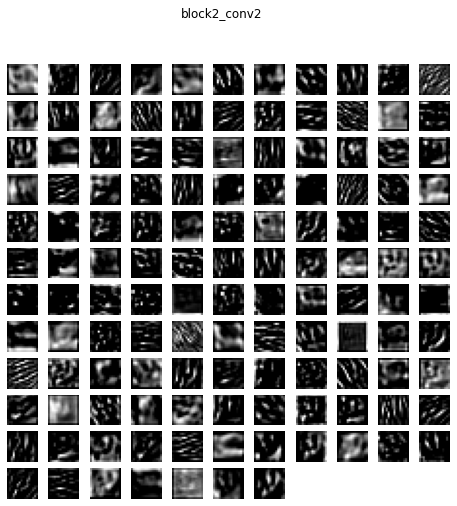

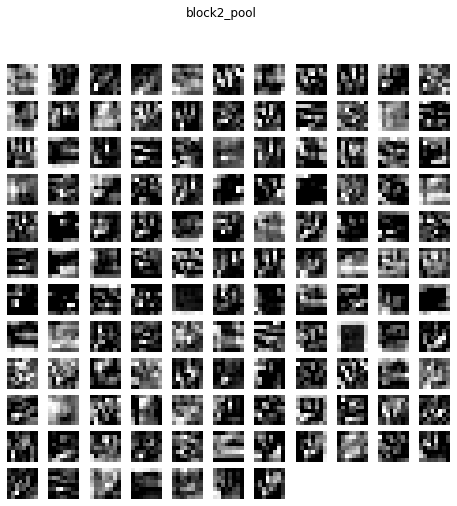

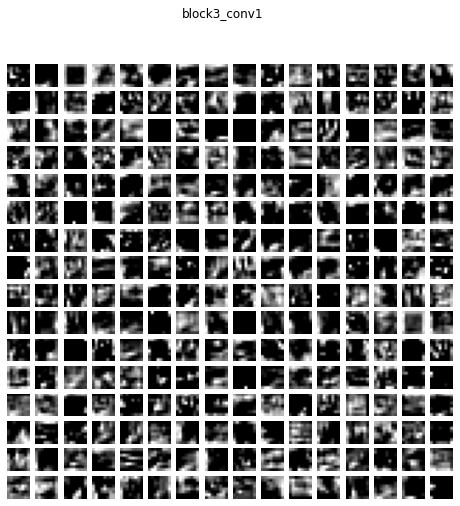

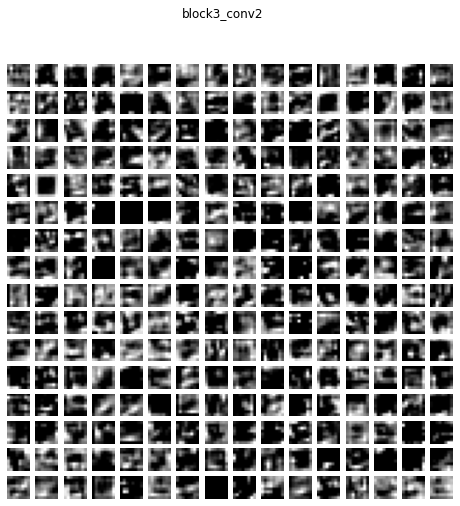

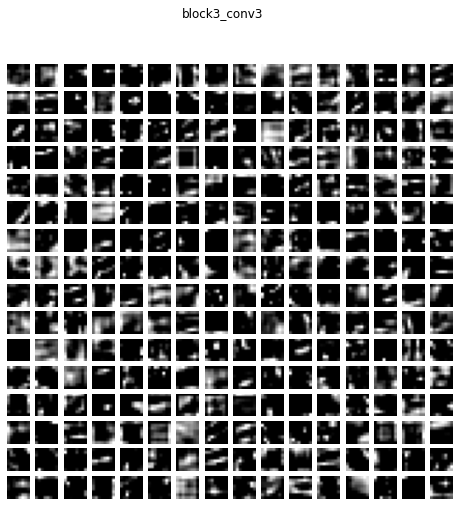

In [51]:
# plot all where each layer is a new figure
for layer_name, layer_activation in zip(layer_names, feature_maps):
    PlotImages(layer_activation, layer_name, layer_activation.shape[3])